In [1]:
import perceval as pcvl
from perceval.algorithm import Sampler
from math import pi
from perceval.components import BS, PS
import numpy as np

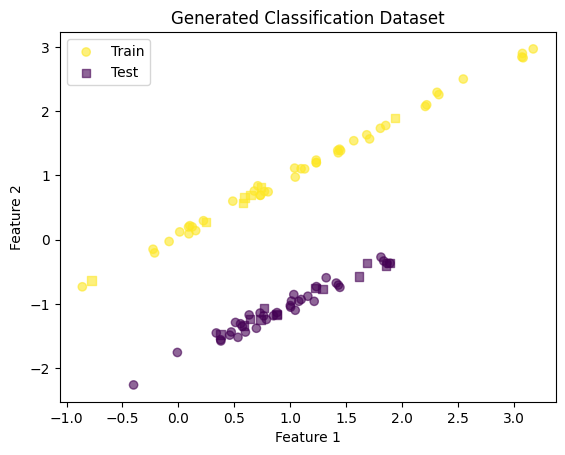

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset with 2 features
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant = 0,random_state=42)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', label="Test", alpha=0.6)
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Classification Dataset")
plt.show()


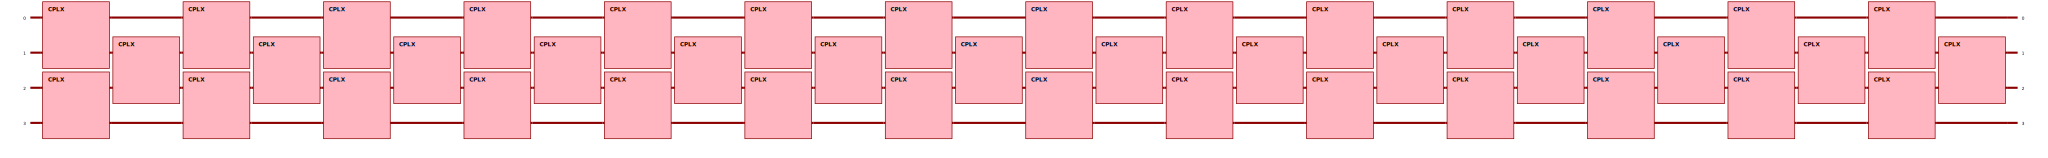

In [3]:
other_ansatz = pcvl.Circuit(4)
other_FM = pcvl.Circuit(4)
other_depth = 10
x1 = pcvl.P(f"x{0}")
x2 = pcvl.P(f"x{1}")
x3 = pcvl.P(f"x{2}")

for i in range(4):
    other_ansatz.add(0, pcvl.Circuit(2) // (0, PS(x1)) // (0, BS()) // (0, PS(x1)) // (0, BS()))
    other_ansatz.add(2, pcvl.Circuit(2) // (0, PS(x2)) // (0, BS()) // (0, PS(x2)) // (0, BS()))
    other_ansatz.add(1, pcvl.Circuit(2) // (0, PS(x3)) // (0, BS()) // (0, PS(x3)) // (0, BS()))

for i in range(other_depth):
    p1 = pcvl.P(f"p{3*i}")
    p2 = pcvl.P(f"p{3*i + 1}")
    p3 = pcvl.P(f"p{3*i + 2}")

    t1 = pcvl.P(f"t{3*i}")
    t2 = pcvl.P(f"t{3*i + 1}")
    t3 = pcvl.P(f"t{3*i + 2}")
    other_ansatz.add(0, pcvl.Circuit(2) // (0, PS(p1)) // (0, BS()) // (0, PS(t1)) // (0, BS()))
    other_ansatz.add(2, pcvl.Circuit(2) // (0, PS(p2)) // (0, BS()) // (0, PS(t2)) // (0, BS()))
    other_ansatz.add(1, pcvl.Circuit(2) // (0, PS(p3)) // (0, BS()) // (0, PS(t3)) // (0, BS()))
pcvl.pdisplay(other_ansatz)

In [4]:
backend = pcvl.SLOSBackend()
vqc1 = pcvl.Circuit(4)
vqc1.add(0,other_FM)
vqc1.add(0,other_ansatz)


vqc1_params = vqc1.get_parameters()

print(vqc1_params)
def get_probs1(data):
    vqc1_params[0].set_value(data[0])
    vqc1_params[1].set_value(data[1])
    vqc1_params[2].set_value((pi - data[0])*(pi - data[1]))
    backend.set_circuit(vqc1)
    results = backend.all_prob(pcvl.BasicState([1,0,0,0]))
    out = results[0] + results[1]
    return out

def loss1(params, data = X_train, target = y_train):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)//2):
        vqc1_params[3+2*i].set_value(params[i])
    for i in range(len(params)//2):
        vqc1_params[4+2*i].set_value(params[i + len(params)//2])
    for i in range(data.shape[0]):
        pred_arr[i] = get_probs1(data[i])
    
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    return loss

[Parameter(name='x0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='x1', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='x2', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p1', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t1', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p2', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t2', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p3', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t3', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p4', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t4', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='p5', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='t5'

In [5]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng().random(size = (other_depth * 6))
arr = []
def callback(intermediate_result: OptimizeResult):
    print(intermediate_result.fun)
    arr.append(intermediate_result.fun)

res = minimize(loss1, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

0.5740119688604663
0.5290676665715417
0.526562490482786
0.5249869005306499
0.5244623253440313
0.5239500147272222
0.5236327393408399
0.5236082328223561
0.52359866101691
0.5235962432310997
0.5235953120554907
0.5235951556322338
0.5235951508078595
0.5235951502924664


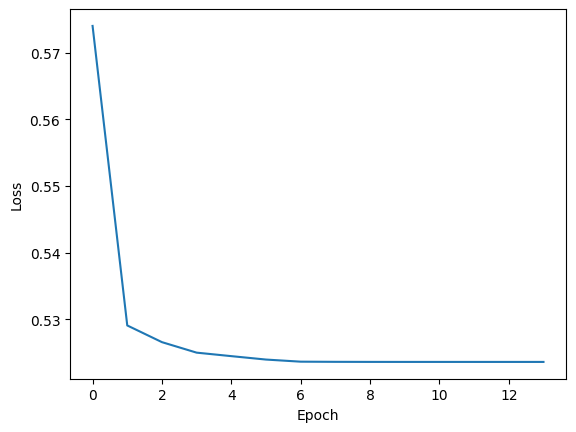

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.plot(arr, linestyle='-')

# Labeling axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plot
plt.show()

In [9]:
# Function to calculate accuracy
def calculate_accuracy(params, x_data, y_true):
    # Get predictions using the trained model
    predictions = np.zeros(shape = (x_data.shape[0]))
    for i in range(len(params)//2):
        vqc1_params[3+2*i].set_value(params[i])
    for i in range(len(params)//2):
        vqc1_params[4+2*i].set_value(params[i + len(params)//2])
    for i in range(x_data.shape[0]):
        predictions[i] = get_probs1(x_data[i])
    predicted_labels = (predictions >= 0.5).astype(int)
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_true)
    return accuracy

opt_params = res.x
# Calculate training accuracy
train_accuracy = calculate_accuracy(opt_params, X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = calculate_accuracy(opt_params, X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8875
Testing Accuracy: 0.7500
